In [1]:
import ssm

/home/ws3/anaconda3/envs/james/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from aind_dynamic_foraging_data_utils import nwb_utils
import aind_dynamic_foraging_basic_analysis.licks.annotation as annotation
from hdmf_zarr import NWBZarrIO
import glob
import os
import numpy as np
%matplotlib inline
# %matplotlib ipympl
from aind_dynamic_foraging_basic_analysis.plot import plot_session_scroller as pss 
import matplotlib.pyplot as plt

In [5]:
# Determine filepath to our data asset
nwb_files = glob.glob('data/**/nwb/**.nwb')

# Load the NWB file
with NWBZarrIO(path=nwb_files[0], mode="r") as io:
    nwb = io.read()

In [6]:
# # Get the absolute path to the data directory
# data_dir = '/Users/lauradriscoll/Documents/code/aind_ssm_hackathon/data'

# # Use glob to find all .nwb files in the data directory and its subdirectories
# nwb_files = glob.glob(os.path.join(data_dir, '**', 'nwb', '*.nwb'), recursive=True)

In [7]:
nwb = nwb_utils.load_nwb_from_filename(nwb_files[0])

In [8]:
nwb.df_trials = nwb_utils.create_df_trials(nwb)
nwb.df_events = nwb_utils.create_events_df(nwb)
nwb.fip_df = nwb_utils.create_fib_df(nwb, tidy=True)
nwb.df_licks = annotation.annotate_lick_bouts(nwb)
nwb.df_licks = annotation.annotate_rewards(nwb)
nwb.df_licks = annotation.annotate_cue_response(nwb)

/home/ws3/Desktop/james/hackathon_allen/aind-dynamic-foraging-data-utils/src/aind_dynamic_foraging_data_utils/nwb_utils.py:380: RuntimeWarning: All-NaN slice encountered
  lambda x: np.nanmin(
/home/ws3/Desktop/james/hackathon_allen/aind-dynamic-foraging-data-utils/src/aind_dynamic_foraging_data_utils/nwb_utils.py:397: RuntimeWarning: All-NaN slice encountered
  lambda x: np.nanmin(np.concatenate([[np.nan], x["right_lick_time"], x["left_lick_time"]])),


In [9]:
import numpy as np
import pandas as pd

def organize_nwb_data(nwb, fluorescence_event = "G_1_dff-poly", interpolate_step=0.1):
    """
    Organize NWB data for dopamine state space modeling.
    
    Parameters:
    nwb : NWBFile
        The NWB file object containing the data
    fluorescence_event : str
        The name of the fluorescence event in nwb.fip_df
    interpolate_step : float, optional
        The time step for interpolation (default is 0.1)
    
    Returns:
    pd.DataFrame
        A dataframe containing the organized data
    """
    # Get events data
    events_df = nwb_utils.create_events_df(nwb)
    
    # Get all unique event types
    event_types = np.unique(events_df['event'])
    
    # Get fluorescence data
    fip_df = nwb.fip_df
    t = fip_df.query(f'event=="{fluorescence_event}"')['timestamps']
    f = fip_df.query(f'event=="{fluorescence_event}"')['data']
    
    if len(t) == 0 or len(f) == 0:
        raise ValueError(f"No data found for fluorescence event '{fluorescence_event}'. Please check the event name.")
    
    # Create a unified time axis
    t_start = min(t.min(), events_df['timestamps'].min())
    t_end = max(t.max(), events_df['timestamps'].max())
    t_unified = np.arange(t_start, t_end, interpolate_step)
    
    # Interpolate fluorescence data to unified time axis
    f_unified = np.interp(t_unified,t, f)
    
    # Create event signals
    event_signals = pd.DataFrame(index=t_unified, columns=event_types)
    for event_type in event_types:
        event_times = events_df[events_df['event'] == event_type]['timestamps']
        event_signals[event_type] = 0
        event_indices = np.searchsorted(t_unified, event_times)
        event_indices = event_indices[event_indices < len(t_unified)]  # Ensure indices are within bounds
        event_signals.iloc[event_indices, event_signals.columns.get_loc(event_type)] = 1
        
    # Combine all data into a single DataFrame
    combined_data = pd.DataFrame({
        'time': t_unified,
        'dopamine_signal': f_unified,
        'goCue_start_time': event_signals['goCue_start_time'],
        'left_lick_time': event_signals['left_lick_time'],
        'left_reward_delivery_time': event_signals['left_reward_delivery_time'],
        'right_lick_time': event_signals['right_lick_time'],
        'right_reward_delivery_time': event_signals['right_reward_delivery_time']

    })


    return combined_data, event_signals

In [10]:
combined_data, event_signals = organize_nwb_data(nwb, interpolate_step=0.1)

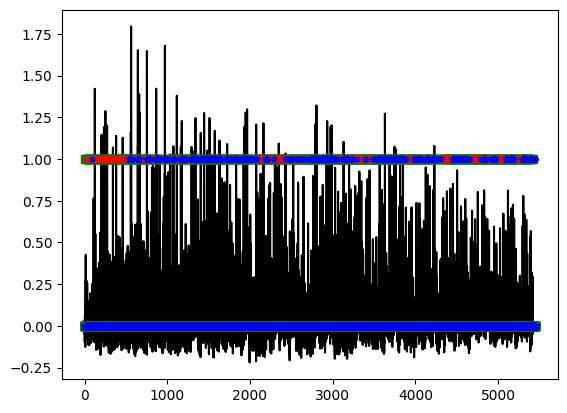

In [15]:
plt.close()
t_start = 0
t_max = len(combined_data['dopamine_signal'])

plt.plot(2*combined_data['dopamine_signal'].loc[t_start:t_max],'-k')
plt.plot(combined_data['goCue_start_time'].loc[t_start:t_max],'sg')
plt.plot(combined_data['right_reward_delivery_time'].loc[t_start:t_max],'*r')
plt.plot(combined_data['right_lick_time'].loc[t_start:t_max],'.r')
plt.plot(combined_data['left_reward_delivery_time'].loc[t_start:t_max],'*b')
plt.plot(combined_data['left_lick_time'].loc[t_start:t_max],'.b')

# plt.xlim([1000, 1100])
plt.show()

In [12]:
observations = combined_data.iloc[:, 0].values.reshape(-1, 1)  # Get first column and reshape to (10000, 1)
inputs = combined_data.iloc[:, 1:].values  # Get remaining columns as numpy array

(60497, 1)


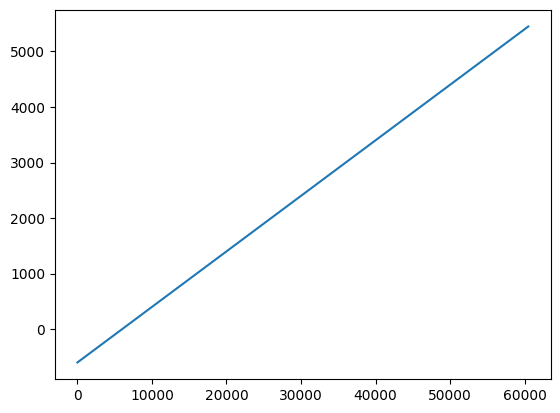

In [17]:
print(observations.shape)
plt.plot(observations[:, 0])

In [61]:
dopamine = 2*combined_data['dopamine_signal'].loc[t_start:t_max].to_numpy()[:, None]

In [63]:
dopamine = np.concatenate([dopamine[:-10], dopamine[1:-9], dopamine[2:-8], dopamine[3:-7], dopamine[4:-6], dopamine[5:-5], dopamine[6:-4], dopamine[7:-3], dopamine[8:-2], dopamine[9:-1], dopamine[10:]], -1)

In [64]:
print(dopamine.shape)

(54491, 11)


In [65]:
print(type(dopamine))

<class 'numpy.ndarray'>


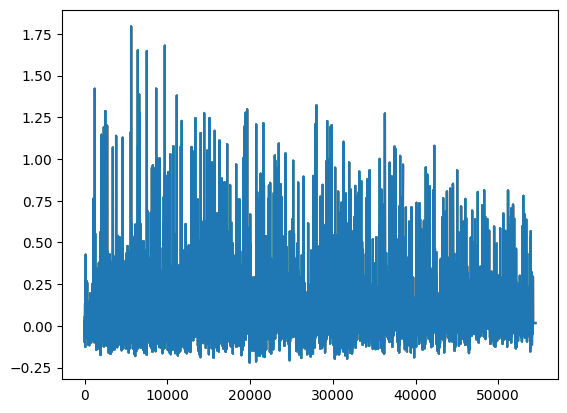

In [66]:
plt.plot(dopamine)

In [67]:
data = dopamine
print(data.shape)
obs_dim, state_dim = dopamine.shape[1], 2

print("Fitting LDS with Laplace-EM using structured variational posterior")
lds = ssm.LDS(obs_dim, state_dim, emissions="gaussian")
elbos, q = lds.fit(data, method="laplace_em", num_iters=10)

# Get the posterior mean of the continuous states
state_means = q.mean_continuous_states[0]

# Smooth the data under the variational posterior
smoothed_obs = lds.smooth(state_means, data)

(54491, 11)
Fitting LDS with Laplace-EM using structured variational posterior


ARHMM Initialization restarts:   0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


ELBO: 866798.6: 100%|██████████| 10/10 [00:22<00:00,  2.27s/it]


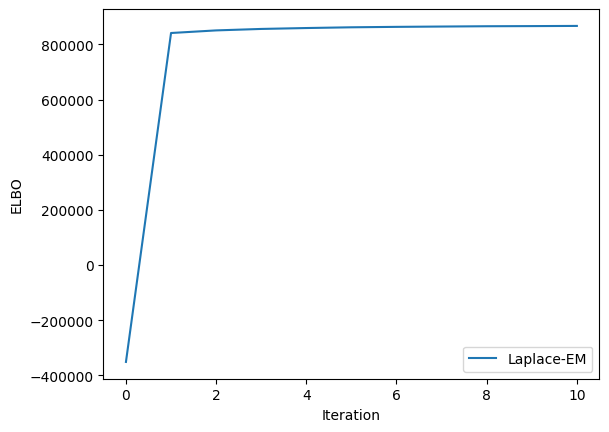

In [68]:
# Plot the ELBOs
plt.plot(elbos, label="Laplace-EM")
plt.xlabel("Iteration")
plt.ylabel("ELBO")
plt.legend()

In [70]:

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")
color_names = ["windows blue",
               "red",
               "amber",
               "faded green",
               "dusty purple",
               "orange",
               "clay",
               "pink",
               "greyish",
               "mint",
               "light cyan",
               "steel blue",
               "forest green",
               "pastel purple",
               "salmon",
               "dark brown"]

colors = sns.xkcd_palette(color_names)

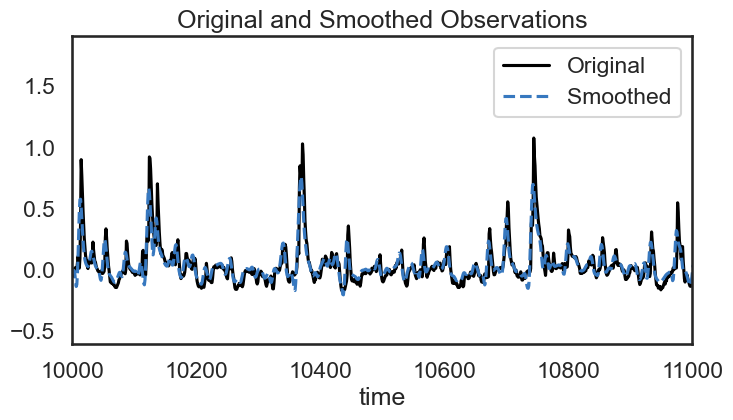

In [89]:
# Plot the smoothed emissions
plt.figure(figsize=(8,4))
for n in range(1):
    plt.plot(data[:, n] + 4 * n, '-k', label="Original" if n == 0 else None)
    plt.plot(smoothed_obs[:, n] + 4 * n, '--', color=colors[0], label="Smoothed" if n == 0 else None)
plt.legend()
plt.xlabel("time")
plt.xlim(10000, 11000)
plt.title("Original and Smoothed Observations")
plt.show()

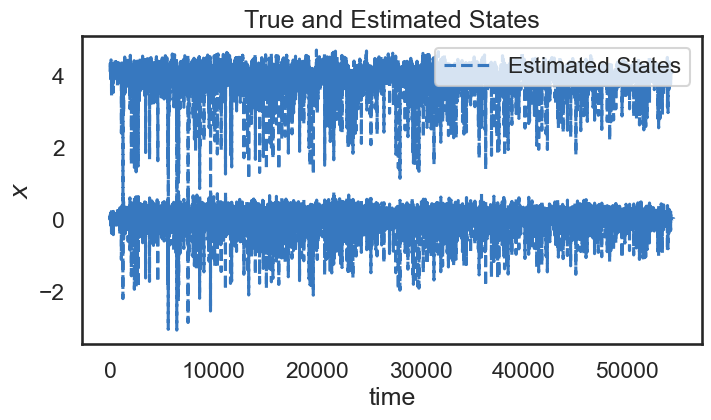

In [76]:
plt.figure(figsize=(8,4))
for d in range(state_dim):
    plt.plot(state_means[:,d] + 4 * d, '--', color=colors[0], label="Estimated States" if d==0 else None)
plt.ylabel("$x$")
plt.xlabel("time")
plt.legend(loc='upper right')
plt.title("True and Estimated States")
plt.show()

In [79]:
import copy

plds = ssm.LDS(obs_dim, state_dim, emissions="poisson_orthog", emission_kwargs=dict(link="softplus"))
plds.dynamics.params = copy.deepcopy(true_lds.dynamics.params)
plds.emissions.ds = 0 * np.ones(obs_dim)
states_plds, obs_plds = plds.sample(time_bins)

NameError: name 'true_lds' is not defined

In [82]:
import copy

plds = ssm.LDS(obs_dim, state_dim, emissions="poisson_orthog", emission_kwargs=dict(link="softplus"))
plds.dynamics.params = copy.deepcopy(true_lds.dynamics.params)
plds.emissions.ds = 0 * np.ones(obs_dim)
states_plds, obs_plds = plds.sample(time_bins)

NameError: name 'true_lds' is not defined

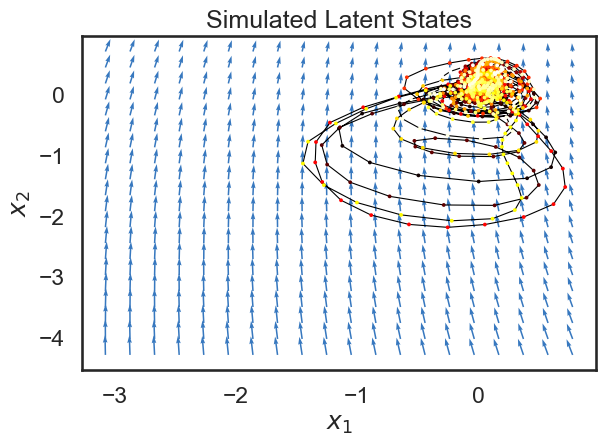

In [104]:
from ssm.plots import plot_dynamics_2d

# Plot the dynamics vector field
plot_dynamics_2d(plds.dynamics.A,
                 plds.dynamics.b,
                 mins=(state_means[:,0].min(),state_means[:,1].min()),
                 maxs=(state_means[:,0].max(),state_means[:,1].max()),
                 color=colors[0])
plt.scatter(state_means[10000:11000,0], state_means[10000:11000,1], cmap = 'hot', c = np.arange(10000, 11000), s = 1.5, zorder=10)
plt.plot(state_means[10000:11000,0], state_means[10000:11000,1], color='black', linewidth = .8)

# plt.plot(states_plds[:,0], states_plds[:,1], '-k', lw=3)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Simulated Latent States")
plt.tight_layout()